In [43]:
#run this to install dependencies
!pip install netrd
!pip install torch_geometric

In [44]:
#all necessary imports here
import torch_geometric.datasets
import torch_geometric.data
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import netrd
from scipy.sparse import csr_matrix, lil_matrix

In [45]:
def plot_degree_dist(G, n = 'Custom'):
  degrees = [G.degree(n) for n in G.nodes()]

  degree_counts = nx.degree_histogram(G)

  plt.xlim(0, max(list(range(len(degree_counts)))))
  plt.bar(range(len(degree_counts)), degree_counts)
  plt.xlabel("Degree")
  plt.ylabel("Count")
  plt.title("Graph " + n)
  plt.xscale("symlog")
  plt.show()

def find_index(a, b, XY, start, end):  #XY-1D array
  l = [0,0]
  for i in range(start, end):
    if XY[i]==a:
      l[0] = i
    elif XY[i]==b:
      l[1] = i
  return l

def compare_find_common(a, b, XY, start, end):  #XY-2D array
  l = [0,0]
  for i in range(start,end):
    if np.array_equal(XY[i],a):
      l[0] = i
    elif np.array_equal(XY[i],b):
      l[1] = i
  return l

def convert(p):
  s = ""
  if p==0:
    print("Euclidean Distance")
    s = "Euclidean Distance"
  elif p==1:
    print("Cosine Similarity")
    s = "Cosine Similarity"
  elif p==2:
    print("Manhattan Distance")
    s = "Manhattan Distance"
  else:
    print("Hamming Distance")
    s = "Hamming Distance"
  return s

def dataset_select(data):
  if data[-1]=='1':
    print("Flickr Dataset selected!")
  elif data[-1]=='2':
    print("Amazon Computers Dataset selected!")
  elif data[-1]=='3':
    print("Attributed Graph Cora Dataset selected!")
  elif data[-1]=='4':
    print("Heterophilus Graph Questions dataset selected!")
  else:
    print("Citation CiteSeer dataset selected!")

In [46]:
dataset1 = torch_geometric.datasets.Flickr("/content")
dataset2 = torch_geometric.datasets.Amazon("/content","Computers")
dataset3 = torch_geometric.datasets.AttributedGraphDataset("/content","Cora")
dataset4 = torch_geometric.datasets.HeterophilousGraphDataset("/content","Questions")
dataset5 = torch_geometric.datasets.CitationFull("/content","CiteSeer")

In [47]:
print("Select one of datasets:-")
y = int(input())
if y not in range(1,6):
  raise AssertionError("Invalid attribute")
if y==1:
  dataset = dataset1
  s = "dataset1"
elif y==2:
  dataset = dataset2
  s = "dataset2"
elif y==3:
  dataset = dataset3
  s = "dataset3"
elif y==4:
  dataset = dataset4
  s = "dataset4"
else:
  dataset = dataset5
  s = "dataset5"

dataset_select(s)

Select one of datasets:-
3
Attributed Graph Cora Dataset selected!


In [48]:
graph_data = dataset[0]  #accessing the graph in the dataset
data = torch_geometric.data.Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y)
data

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])

In [49]:
set_data = data.__dict__ #converting data object to dictionary
dataset_report = pd.DataFrame(index = ["Number of Nodes", "Number of Node Features", "Number of Edges"])
dataset_report['0'] = [set_data['_store']['x'].shape[0], set_data['_store']['x'].shape[1], set_data['_store']['edge_index'].shape[1]]
dataset_report.to_csv("dataset_report_"+s+".csv") #saving dataset descriptive stats as csv file

In [50]:
node_features = pd.DataFrame(data.x.numpy())
edge_indices = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target']) #denotes the source and destination nodes starting from 0
node_labels = pd.DataFrame(data.y.numpy(), columns=['label']) #denotes the community to which an edge belongs
graph_df = pd.concat([node_features, edge_indices, node_labels], axis=1)
graph_df.dropna(inplace=True)
graph_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1426,1427,1428,1429,1430,1431,1432,source,target,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,163,402,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163,659,6.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163,1696,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163,2295,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163,1274,4.0


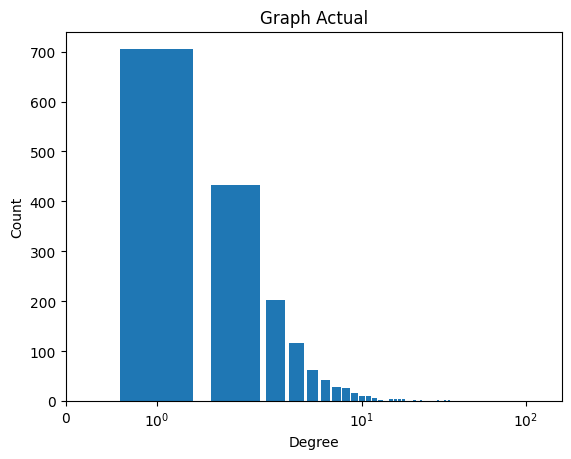

In [51]:
data = graph_df[['source', 'target']]
data = data.to_numpy()
G_true = nx.Graph() #creating the actual(Ground truth) graph from the dataset
for i in range(data.shape[0]):
  G_true.add_edge(data[i][0], data[i][1])
plot_degree_dist(G_true, 'Actual') #using symmetrical log scale for x-axis (refer:- https://matplotlib.org/stable/api/scale_api.html#matplotlib.scale.SymmetricalLogScale)

In [52]:
cols = graph_df.columns
cols = list(cols)
cols.remove('target')
cols.remove('label')

In [53]:
feature_df = graph_df.loc[:,cols]
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,source
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,163
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163


In [54]:
X = feature_df.drop("source", axis=1)
cols.remove('source')
X = X.loc[:, cols]
X = X.to_numpy()

In [55]:
#euclidean distance

batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

XY = X.sum(1)
D = np.zeros((num_points, num_points), dtype=np.float16)
#D = np.full((num_points, num_points), np.inf)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = XY[start_idx:end_idx]

    # Compute norms for the current batch
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = start_idx + i, start_idx + j
            if batch_XY[i] == batch_XY[j]:
              D[idx1][idx2] = 1.0
              continue
            D[idx1][idx2] = np.linalg.norm(batch_XY[i] - batch_XY[j])

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = XY[start_idx:]

    # Compute norms for the remaining points
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = start_idx + i, start_idx + j
            if batch_XY[i] == batch_XY[j]:
              D[idx1][idx2] = 1.0
              continue
            D[idx1][idx2] = np.linalg.norm(batch_XY[i] - batch_XY[j])

In [56]:
D

array([[0., 3., 2., ..., 0., 0., 0.],
       [3., 0., 5., ..., 0., 0., 0.],
       [2., 5., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float16)

In [57]:
th = 2.00  # threshold for determining similarity between nodes on the basis of Euclidean distance

batch_size = 1000  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

A = csr_matrix((num_points, num_points), dtype=bool)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = D[start_idx:end_idx, :]

    # Compare for the current batch
    A[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th))

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = D[start_idx:]

    # Compare for the remaining points
    A[start_idx:, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th))

/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [58]:
A

<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 5276 stored elements and shape (2708, 2708)>

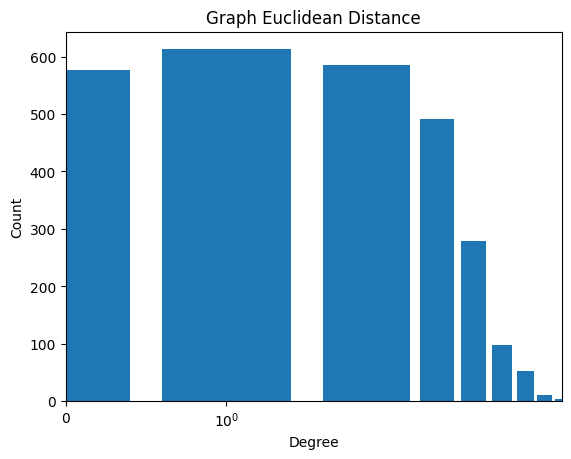

In [59]:
G = nx.Graph(A.toarray())   #predicting graph for Euclidean Distance

plot_degree_dist(G, 'Euclidean Distance') #using symmetrical log scale for x-axis (refer:- https://matplotlib.org/stable/api/scale_api.html#matplotlib.scale.SymmetricalLogScale)

In [60]:
#cosine similarity

Cos = np.zeros((X.shape[0], X.shape[0]))
#Cos = np.full((num_points, num_points), np.inf)

batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = X[start_idx:end_idx, :]

    # Compute cosine similarities for the current batch
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = start_idx + i, start_idx + j
            Cos[idx1][idx2] = scipy.spatial.distance.cosine(batch_XY[i, :], batch_XY[j, :])*(-1) + 1
            if Cos[idx1][idx2]==0:
              Cos[idx1][idx2]=0.13

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = X[start_idx:]

    # Compute cosine similarities for the remaining points
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = start_idx + i, start_idx + j
            Cos[idx1][idx2] = scipy.spatial.distance.cosine(batch_XY[i, :], batch_XY[j, :])*(-1) + 1
            if Cos[idx1][idx2]==0:
              Cos[idx1][idx2]=0.13

In [61]:
Cos

array([[0.        , 0.13      , 0.13      , ..., 0.        , 0.        ,
        0.        ],
       [0.13      , 0.        , 0.15512633, ..., 0.        , 0.        ,
        0.        ],
       [0.13      , 0.15512633, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.13      ,
        0.13      ],
       [0.        , 0.        , 0.        , ..., 0.13      , 0.        ,
        0.13      ],
       [0.        , 0.        , 0.        , ..., 0.13      , 0.13      ,
        0.        ]])

In [62]:
#compute predicted graph using Cosine Similarity
th1 = 0.051  #threshold for determining similarity between nodes on basis of Cosine Similarity

batch_size = 1000  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

A1 = csr_matrix((num_points, num_points), dtype=bool)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = Cos[start_idx:end_idx, :]

    # Compare for the current batch
    A1[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th1))

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = Cos[start_idx:]

    # Compare for the remaining points
    A1[start_idx:, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th1))

In [63]:
A1

<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 3508 stored elements and shape (2708, 2708)>

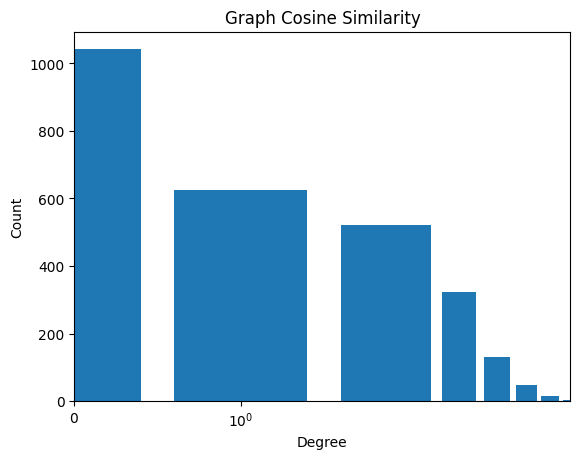

In [64]:
G1 = nx.Graph(A1.toarray())   #predicting graph for Cosine Similarity

plot_degree_dist(G1, 'Cosine Similarity') #using symmetrical log scale for x-axis (refer:- https://matplotlib.org/stable/api/scale_api.html#matplotlib.scale.SymmetricalLogScale)

In [65]:
#manhattan distance

Man = np.zeros((X.shape[0], X.shape[0]))
#Man = np.full((X.shape[0], X.shape[0]), np.inf)

batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = X[start_idx:end_idx, :]

    # Compute manhattan distances for the current batch
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = start_idx + i, start_idx + j
            Man[idx1][idx2] = sum(np.abs(batch_XY[i, :] - batch_XY[j, :]))
            if Man[idx1][idx2]==0:
              Man[idx1][idx2]=44

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = X[start_idx:]

    # Compute manhattan distances for the remaining points
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = start_idx + i, start_idx + j
            Man[idx1][idx2] = sum(np.abs(batch_XY[i, :] - batch_XY[j, :]))
            if Man[idx1][idx2]==0:
              Man[idx1][idx2]=44

In [66]:
Man

array([[ 0., 37., 42., ...,  0.,  0.,  0.],
       [37.,  0., 33., ...,  0.,  0.,  0.],
       [42., 33.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., 37., 37.],
       [ 0.,  0.,  0., ..., 37.,  0., 38.],
       [ 0.,  0.,  0., ..., 37., 38.,  0.]])

In [67]:
#compute predicted graph using Manhattan Distance
th2 = 24.6  #threshold for determining similarity between nodes on basis of Manhattan Distance

batch_size = 1000  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

A2 = csr_matrix((num_points, num_points), dtype=bool)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = Man[start_idx:end_idx, :]

    # Compare for the current batch
    A2[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th2))

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = Man[start_idx:]

    # Compare for the remaining points
    A2[start_idx:, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th2))

In [68]:
A2

<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 3222 stored elements and shape (2708, 2708)>

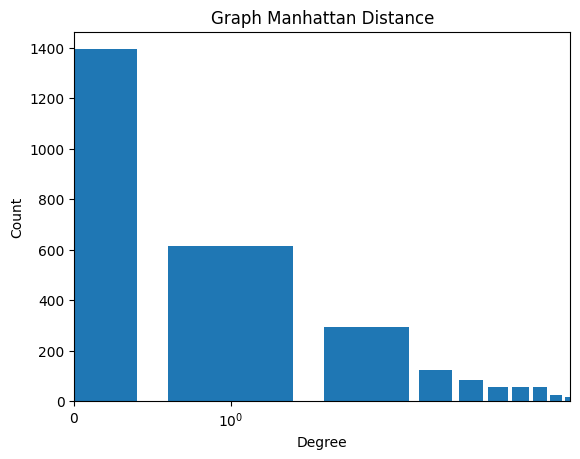

In [69]:
G2 = nx.Graph(A2.toarray())  #predicting graph for Manhattan Distance

plot_degree_dist(G2, 'Manhattan Distance') #using symmetrical log scale for x-axis (refer:- https://matplotlib.org/stable/api/scale_api.html#matplotlib.scale.SymmetricalLogScale)

In [70]:
#hamming distance can also refer netrd documentation: https://netrd.readthedocs.io/en/latest/distance.html#netrd.distance.Hamming

thd = 0.6375
batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):   #set binary strings for features of nodes
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = X[start_idx:end_idx, :]
    X[start_idx:end_idx] = np.where(batch_XY < thd, 1, 0)

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = X[start_idx:]
    X[start_idx:] = np.where(batch_XY < thd, 1, 0)

In [71]:
#compute hamming distance

Ham = np.zeros((X.shape[0], X.shape[0]))
#Ham = np.full((X.shape[0], X.shape[0]), np.inf)

batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = X[start_idx:end_idx, :]

    # Compute hamming distance for the current batch
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i == j:
                continue
            idx1, idx2 = start_idx + i, start_idx + j
            Ham[idx1][idx2] = np.logical_xor(batch_XY[i, :], batch_XY[j, :]).sum()
            if Ham[idx1][idx2]==0:
              Ham[idx1][idx2]=35

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = X[start_idx:]

    # Compute hamming distance for the remaining points
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i == j:
                continue
            idx1, idx2 = start_idx + i, start_idx + j
            Ham[idx1][idx2] = np.logical_xor(batch_XY[i, :], batch_XY[j, :]).sum()
            if Ham[idx1][idx2]==0:
              Ham[idx1][idx2]=35

In [72]:
Ham

array([[ 0., 37., 42., ...,  0.,  0.,  0.],
       [37.,  0., 33., ...,  0.,  0.,  0.],
       [42., 33.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., 37., 37.],
       [ 0.,  0.,  0., ..., 37.,  0., 38.],
       [ 0.,  0.,  0., ..., 37., 38.,  0.]])

In [73]:
#compute predicted graph using Hamming Distance
th3 = 39  #threshold for determining similarity between nodes on basis of Hamming Distance

batch_size = 1000  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

A3 = csr_matrix((num_points, num_points), dtype=bool)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = Ham[start_idx:end_idx, :]

    # Compare for the current batch
    A3[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th3))

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = Ham[start_idx:]

    # Compare for the remaining points
    A3[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th3))

In [74]:
A3

<Compressed Sparse Row sparse matrix of dtype 'bool'
	with 16316 stored elements and shape (2708, 2708)>

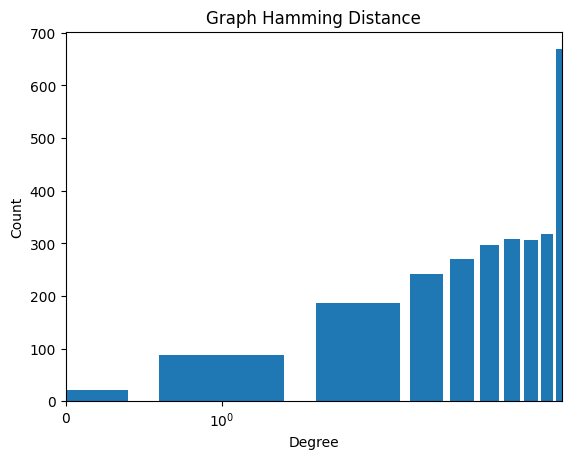

In [75]:
G3 = nx.Graph(A3.toarray())  #predicting graph for Hamming Distance

plot_degree_dist(G3, 'Hamming Distance') #using symmetrical log scale for x-axis (refer:- https://matplotlib.org/stable/api/scale_api.html#matplotlib.scale.SymmetricalLogScale)

In [76]:
G_true  #actual(Ground truth value) graph estimated from the dataset

In [77]:
#For Jaccard distance refer: https://netrd.readthedocs.io/en/latest/distance.html#netrd.distance.JaccardDistance

obj = netrd.distance.JaccardDistance()
#corresponding jaccard distance comparsions between predicted and ground truth
y = obj.dist(G, G_true) #euclidean distance
y_1 = obj.dist(G1, G_true) #cosine similarity
y_2 = obj.dist(G2, G_true) #manhattan distance
y_3 = obj.dist(G3, G_true) #hamming distance

print("***Jaccard Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ",y)
print("2) Ground truth vs estimated (Cosine):- ",y_1)
print("3) Ground truth vs estimated (Manhattan):- ",y_2)
print("4) Ground truth vs estimated (Hamming):- ",y_3)

l_jacc = [y, y_1, y_2, y_3]

***Jaccard Similarity Summary***
1) Ground truth vs estimated (Euclidean):-  0.9979292168674698
2) Ground truth vs estimated (Cosine):-  0.9995492449853505
3) Ground truth vs estimated (Manhattan):-  0.9979006298110566
4) Ground truth vs estimated (Hamming):-  0.9962973248171804


In [78]:
#jensen shannon divergence
#*******given below******* link:- https://netrd.readthedocs.io/en/latest/distance.html

#compute js divergence between predicted and groud truth
obj1 = netrd.distance.DegreeDivergence()
jsdy = obj1.dist(G, G_true) #euclidean distance
jsdy_1 = obj1.dist(G1, G_true) #cosine similarity
jsdy_2 = obj1.dist(G2, G_true) #manhattan distance
jsdy_3 = obj1.dist(G3, G_true) #hamming distance

print("***Jensen Shannon Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ",jsdy)
print("2) Ground truth vs estimated (Cosine):- ",jsdy_1)
print("3) Ground truth vs estimated (Manhattan):- ",jsdy_2)
print("4) Ground truth vs estimated (Hamming):- ",jsdy_3)

l_js = [jsdy, jsdy_1, jsdy_2, jsdy_3]

***Jensen Shannon Similarity Summary***
1) Ground truth vs estimated (Euclidean):-  0.1761699169009883
2) Ground truth vs estimated (Cosine):-  0.2724863944852886
3) Ground truth vs estimated (Manhattan):-  0.3539878088084564
4) Ground truth vs estimated (Hamming):-  0.42171554221948315


In [79]:
#graph node signature distribution similarity
#reference: https://netrd.readthedocs.io/en/latest/distance.html#netrd.distance.NetSimile

obj2 = netrd.distance.NetSimile()
nsy = obj2.dist(G, G_true) #euclidean distance
nsy_1 = obj2.dist(G1, G_true) #cosine similarity
nsy_2 = obj2.dist(G2, G_true) #manhattan distance
nsy_3 = obj2.dist(G3, G_true) #hamming distance

print("***Graph Node Signature Distribution Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ",nsy)
print("2) Ground truth vs estimated (Cosine):- ",nsy_1)
print("3) Ground truth vs estimated (Manhattan):- ",nsy_2)
print("4) Ground truth vs estimated (Hamming):- ",nsy_3)

l_ns = [nsy, nsy_1, nsy_2, nsy_3]

***Graph Node Signature Distribution Similarity Summary***
1) Ground truth vs estimated (Euclidean):-  23.525161794578775
2) Ground truth vs estimated (Cosine):-  20.457637554758414
3) Ground truth vs estimated (Manhattan):-  21.126480891565695
4) Ground truth vs estimated (Hamming):-  23.876795920269842


In [80]:
#Onion distance between graphs based on their adjacency matrices
#reference: https://netrd.readthedocs.io/en/latest/distance.html#netrd.distance.OnionDivergence

obj3 = netrd.distance.OnionDivergence()
froby = obj3.dist(G, G_true) #euclidean distance
froby_1 = obj3.dist(G1, G_true) #cosine similarity
froby_2 = obj3.dist(G2, G_true) #manhattan distance
froby_3 = obj3.dist(G3, G_true) #hamming distance

print("***Onion Distance Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ",froby)
print("2) Ground truth vs estimated (Cosine):- ",froby_1)
print("3) Ground truth vs estimated (Manhattan):- ",froby_2)
print("4) Ground truth vs estimated (Hamming):- ",froby_3)

l_frob = [froby, froby_1, froby_2, froby_3]

***Onion Distance Similarity Summary***
1) Ground truth vs estimated (Euclidean):-  0.8175031473320635
2) Ground truth vs estimated (Cosine):-  0.6699300444420533
3) Ground truth vs estimated (Manhattan):-  0.6371141127221097
4) Ground truth vs estimated (Hamming):-  0.9077628210210628


In [81]:
m1 = max(l_jacc)
m2 = min(l_js)
m3 = min(l_ns)
m4 = min(l_frob)
l1 = find_index(m1, None, l_jacc, 0, 4)
l2 = find_index(m2, None, l_js, 0, 4)
l3 = find_index(m3, None, l_ns, 0, 4)
l4 = find_index(m4, None, l_frob, 0, 4)
i = convert(l1[0])  #closer graph metric as per Jaccard similarity
j = convert(l2[0])  #closer graph metric as per JS divergence similarity
k = convert(l3[0])  #closer graph metric as per Node Signature similarity
l = convert(l4[0])  #closer graph metric as per Onion Degree Divergence similarity

Cosine Similarity
Euclidean Distance
Cosine Similarity
Manhattan Distance


In [82]:
'''
TODO1 : Till the work done above, summarise all your readings and observations for
each dataset in the form of a table. Justify them using values obtained
(5 tables for 5 datasets)

TODO2: For each dataset, generate its descriptive statistics (number of nodes,
number of node features, etc) (5 tables for 5 datasets)
'''

'\nTODO1 : Till the work done above, summarise all your readings and observations for\neach dataset in the form of a table. Justify them using values obtained\n(5 tables for 5 datasets)\n\nTODO2: For each dataset, generate its descriptive statistics (number of nodes,\nnumber of node features, etc) (5 tables for 5 datasets)\n'

In [83]:
report = pd.DataFrame(index = ['Euclidean Distance', 'Cosine Similarity', 'Manhattan Distance', 'Hamming Distance'])
report['Jaccard Distance'] = l_jacc
report['JS Divergence'] = l_js
report['Netsimile Divergence'] = l_ns
report['Onion Divergence'] = l_frob
report['Threshold Value'] = [th, th1, th2, th3]
report['Hamming Threshold'] = [0, 0, 0, thd]

final_results = pd.DataFrame(index = ['Euclidean Distance', 'Cosine Similarity', 'Manhattan Distance', 'Hamming Distance'])
final_results['Jaccard Distance'] = ['Not Close: {}'.format(l_jacc[0]), 'Not Close: {}'.format(l_jacc[1]), 'Not Close: {}'.format(l_jacc[2]), 'Not Close: {}'.format(l_jacc[3])]
final_results['JS Divergence'] = ['Not Close: {}'.format(l_js[0]), 'Not Close: {}'.format(l_js[1]), 'Not Close: {}'.format(l_js[2]), 'Not Close: {}'.format(l_js[3])]
final_results['Netsimile Divergence'] = ['Not Close: {}'.format(l_ns[0]), 'Not Close: {}'.format(l_ns[1]), 'Not Close: {}'.format(l_ns[2]), 'Not Close: {}'.format(l_ns[3])]
final_results['Onion Divergence'] = ['Not Close: {}'.format(l_frob[0]), 'Not Close: {}'.format(l_frob[1]), 'Not Close: {}'.format(l_frob[2]), 'Not Close: {}'.format(l_frob[3])]
final_results['Jaccard Distance'][i] = 'Close: {}'.format(m1)
final_results['JS Divergence'][j] = 'Close: {}'.format(m2)
final_results['Netsimile Divergence'][k] = 'Close: {}'.format(m3)
final_results['Onion Divergence'][l] = 'Close: {}'.format(m4)


/tmp/ipython-input-2968617980.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  final_results['Jaccard Distance'][i] = 'Close: {}'.format(m1)
/tmp/ipython-input-2968617980.py:15: FutureWarning: ChainedAssignmentError: behaviour will chang

In [84]:
report #printing report

,Jaccard Distance,JS Divergence,Netsimile Divergence,Onion Divergence,Threshold Value,Hamming Threshold
Euclidean Distance,0.997929,0.176170,23.525162,0.817503,2.000,0.0000
Cosine Similarity,0.999549,0.272486,20.457638,0.669930,0.051,0.0000
Manhattan Distance,0.997901,0.353988,21.126481,0.637114,24.600,0.0000
Hamming Distance,0.996297,0.421716,23.876796,0.907763,39.000,0.6375


In [85]:
final_results #printing final observations

,Jaccard Distance,JS Divergence,Netsimile Divergence,Onion Divergence
Euclidean Distance,Not Close: 0.9979292168674698,Close: 0.1761699169009883,Not Close: 23.525161794578775,Not Close: 0.8175031473320635
Cosine Similarity,Close: 0.9995492449853505,Not Close: 0.2724863944852886,Close: 20.457637554758414,Not Close: 0.6699300444420533
Manhattan Distance,Not Close: 0.9979006298110566,Not Close: 0.3539878088084564,Not Close: 21.126480891565695,Close: 0.6371141127221097
Hamming Distance,Not Close: 0.9962973248171804,Not Close: 0.42171554221948315,Not Close: 23.876795920269842,Not Close: 0.9077628210210628


In [86]:
#creating csv files
report.to_csv("report_"+s+".csv")
final_results.to_csv("final_results_"+s+".csv")

In [87]:
#zipping together csv files
import zipfile as zp

with zp.ZipFile("table_"+s+".zip",'w') as zipf:
  zipf.write("report_"+s+".csv")
  zipf.write("final_results_"+s+".csv")
  zipf.write("dataset_report_"+s+".csv")